## 03. Basic statistics
**21 March 2025 by MiniUFO**

---
[TOC]

---
### 1. Introduction
With `pairs` information and `get_variable` method, we can load all position and velocity data into memory for further calculation.  Here we demonstrate how to perform these calculations which are common in relative dispersion analyses.

---

### 2. Calculation
#### 2.1 load the GLAD dataset and get original pairs

In [1]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../../../')
from xdispersion import RelativeDispersion

drifters = xr.open_dataset('../../../data/glad32.nc')

rd = RelativeDispersion(drifters, maxtlen=4*24*85, ragged=True, ID='traj',
                        xpos='longitude', uvel='ve', time='time', Rearth=6371.2,
                        ypos='latitude' , vvel='vn', coord='latlon')

pairs = rd.get_all_pairs()

# filter original pairs from all pairs
condition = np.logical_and(pairs.r0>=0.08, pairs.r0<=0.18)
origin_pairs = pairs.where(condition, drop=True).astype(pairs.dtypes)
origin_pairs

there are 43518 pairs of particles


<xarray.Dataset>
Dimensions:   (pair: 171, particle: 2)
Coordinates:
  * pair      (pair) int32 5716 6266 6539 7083 7883 ... 43389 43396 43425 43463
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) int32 3557 3142 3759 1999 3661 ... 2872 1314 4296 8039 3514
    stim      (pair) datetime64[ns] 2012-07-22T12:45:00 ... 2012-07-22T16:30:00
    r0        (pair) float32 0.08872 0.18 0.09602 ... 0.1259 0.09732 0.08311
    pID       (pair, particle) int32 20 21 22 23 23 24 ... 281 282 283 285 286
    xpos0     (pair, particle) float32 -88.2 -88.2 -88.2 ... -88.09 -88.08
    ypos0     (pair, particle) float32 28.8 28.8 28.8 28.8 ... 27.89 28.84 28.84
    idxI      (pair, particle) int32 121691 125248 134108 ... 1556133 1559647
    idxJ      (pair, particle) int32 130550 134107 137250 ... 1559647 1563161

#### 2.2 Extract variables for relative dispersion
To plot the full trajectories of any pairs, one need to load the positional variables into memory.  Note that loading the full data requires **padding with nans** so that the returned variables are not memory efficient.  With selected original pairs, this is not a serious problem.

In [2]:
from xdispersion.utils import geodist

lons = np.deg2rad(rd.get_variable(origin_pairs, 'longitude')) # change unit to radian
lats = np.deg2rad(rd.get_variable(origin_pairs, 'latitude'))  # change unit to radian

lon1 = lons.isel(particle=0)
lon2 = lons.isel(particle=1)
lat1 = lats.isel(particle=0)
lat2 = lats.isel(particle=1)

# get relative dispersion
r2  = (geodist(lon1, lon2, lat1, lat2) * rd.Rearth) ** 2.0 # this is single realizations
r2m = r2.mean('pair') # this is ensemble averaged dispersion

Now we plot the averaged relative dispersion on a log-log plot

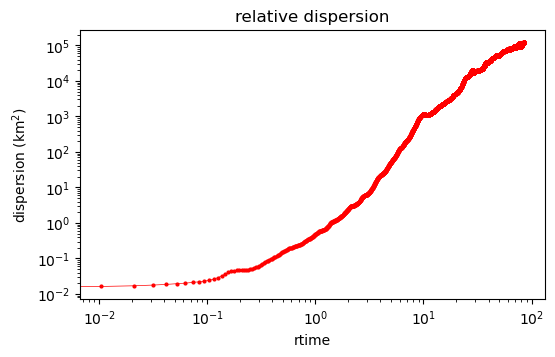

In [3]:
import matplotlib.pyplot as plt

r2m.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5)
plt.title('relative dispersion')
plt.ylabel('rtime (day)')
_ = plt.ylabel('dispersion (km$^2$)')

#### 2.3 Bootstrapping over pairs

There are 171 original pairs and thus 171 realizations of relative dispersion.  One need to bootstrap over these pairs to see the robustness of the statistics.  Bootstrapping is done many times by re-sampling these 171 pairs with replacement (allowing re-sample the same pair).  Here we bootstrap 1000 times to obtain the upper and lower bounds of relative dispersion.

In [4]:
from xdispersion.utils import bootstrap

def func(r2):
    # define a function to tell bootstrap how to get a mean sample
    return r2.mean('pair')

lower, upper = bootstrap(func, [r2], {}, ensemble=1000, CI=0.95)

Now we plot the dispersion with confidence interval or errorbars

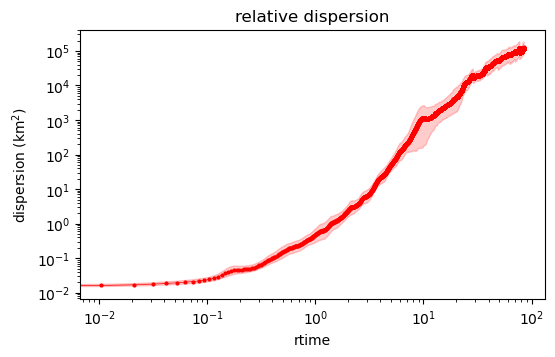

In [7]:
import matplotlib.pyplot as plt

r2m.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1)
plt.fill_between(r2m.rtime, lower, upper, alpha=0.2, color='r', zorder=-5)
plt.title('relative dispersion')
plt.ylabel('rtime (day)')
_ = plt.ylabel('dispersion (km$^2$)')

### 3. Conclusions

This is a basic computational workflow:
- select drifter pairs,
- load data into memory,
- calculate targeted dispersion measures,
- bootstrap the confidence intervals for the measure, and
- plot the results.

Now we need to check whether the dispersion follows certain theoretical prediction, for example, Richardson's $t^3$ behavior.